In [1]:
# Fit notebook to browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import ROOT
import math 
import time
import os
import numpy as np
from array import array
import uproot
import pandas as pd

Welcome to JupyROOT 6.22/02


In [3]:
# Get input TTree
dir_base = '/grid_mnt/vol_home/llr/cms/portales/HIGtrigger/higgs-trigger-nanoaod/CMSSW_10_6_18/src/'
dir_in = dir_base + 'higgs-trigger-nano/'

DFs = {}

file_in = dir_in + 'ntuple_24ABC_muon.root'
#file_in = dir_in + 'histos_24B_Muon.v1.root'
the_tree = uproot.open(file_in)['VBFNanoAOD/VBFtree']
df = ROOT.RDataFrame('VBFNanoAOD/VBFtree',file_in)

DFs['24B'] = df


file_in2 = dir_base + 'higgs-trigger-nanoaod/VBFparking_scripts/' + 'outputs/Run23all_VBFall.fixL1.root'
the_tree2 = uproot.open(file_in2)['VBFNanoAOD/VBFtree']
df2 = ROOT.RDataFrame('VBFNanoAOD/VBFtree',file_in2)

DFs['23all'] = df2




In [4]:
# highest mjj among all jet pairs (with pT>60 GeV, id tight) + additional variables for VBF jets
ROOT.gInterpreter.Declare('''
float get_VBF_var(TString var,
                  ROOT::VecOps::RVec<Float_t> pt,
                  ROOT::VecOps::RVec<Float_t> eta,
                  ROOT::VecOps::RVec<Float_t> phi,
                  ROOT::VecOps::RVec<Float_t> id,
                  ROOT::VecOps::RVec<Float_t> chf,
                  ROOT::VecOps::RVec<Float_t> rawfactor,
                  Float_t pt1cut,
                  Float_t pt2cut,
                  Float_t idcut,
                  Bool_t applyRawFactor) {
    
    Double_t mjj      = -1;
    Double_t detajj   = -1;
    Double_t etabest  = -999;
    Double_t etabest2 = -999;
    Double_t ptbest  = -999;
    Double_t ptbest2 = -999;
    Double_t chfbest  = -1;
    Double_t chfbest2 = -1;
    
    const auto size = pt.size();
    for (size_t idx1=0; idx1<size; ++idx1){
        for (size_t idx2=0; idx2<idx1; ++idx2){
        
            // VBF jets have to pass the ptcut2
            if (pt[idx1]<pt2cut || pt[idx2]<pt2cut)
                continue;
                           
            // in any case, we want tightly ID'd jets (just a safety, the condition should never be true)
            if (id[idx1]<idcut || id[idx2]<idcut)
                continue;
            
            // if minimal selection applies, get thtPt
            ROOT::Math::PtEtaPhiMVector p1,p2;
            if(!applyRawFactor){
                p1.SetPt(pt[idx1]).SetEta(eta[idx1]).SetPhi(phi[idx1]).SetM(0.);
                p2.SetPt(pt[idx2]).SetEta(eta[idx2]).SetPhi(phi[idx2]).SetM(0.);
            } else {
                p1.SetPt(pt[idx1]*(1.-rawfactor[idx1])).SetEta(eta[idx1]).SetPhi(phi[idx1]).SetM(0.);
                p2.SetPt(pt[idx2]*(1.-rawfactor[idx2])).SetEta(eta[idx2]).SetPhi(phi[idx2]).SetM(0.);
            }
            // check if the pair has best mjj, if so store VBF jets quantities
            if ((p1+p2).mass() > mjj) {
                mjj      = (p1+p2).mass();
                detajj   = abs(eta[idx1]-eta[idx2]);
                etabest  = (p1.pt()>p2.pt()) ? p1.eta():p2.eta();
                etabest2 = (p1.pt()>p2.pt()) ? p2.eta():p1.eta();
                ptbest   = (p1.pt()>p2.pt()) ? p1.pt():p2.pt();
                ptbest2  = (p1.pt()>p2.pt()) ? p2.pt():p1.pt();
                chfbest  = (p1.pt()>p2.pt()) ? chf[idx1]:chf[idx2];
                chfbest2 = (p1.pt()>p2.pt()) ? chf[idx2]:chf[idx1];
            }
        }
    }
    if (var=="mjj") 
        return mjj;
    if (var=="detajj")
        return detajj;
    if (var=="eta")
        return etabest;
    if (var=="eta2")
        return etabest2;
    if (var=="pt")
        return ptbest;
    if (var=="pt2")
        return ptbest2;
    if (var=="chf")
        return chfbest;
    if (var=="chf2")
        return chfbest2;
        
    return -999.;
}
'''
)

True

In [5]:
# highest mjj among all jet pairs (with pT>60 GeV, id tight) + additional variables for VBF jets
ROOT.gInterpreter.Declare('''
float get_mjj_dumb(TString var,
                  ROOT::VecOps::RVec<Float_t> pt,
                  ROOT::VecOps::RVec<Float_t> eta,
                  ROOT::VecOps::RVec<Float_t> phi) {
    
            ROOT::Math::PtEtaPhiMVector pp1(pt[0], eta[0], phi[0], 0.);
            ROOT::Math::PtEtaPhiMVector pp2(pt[1], eta[1], phi[1], 0.);
            return (pp1+pp2).mass();
}
'''
)

True

In [6]:
def fill_eff(h_num, h_den, year,var,version):
    eff = ROOT.TGraphAsymmErrors(h_num[year][var][version].GetValue(),
                                 h_den[year][var].GetValue(),
                                 'eff_{}'.format(var))
    return eff

def redrawBorder():
    ROOT.gPad.Update()
    ROOT.gPad.RedrawAxis()
    l = ROOT.TLine()
    l.SetLineWidth(2)
    l.DrawLine(ROOT.gPad.GetUxmin(), ROOT.gPad.GetUymax(), ROOT.gPad.GetUxmax(), ROOT.gPad.GetUymax())
    l.DrawLine(ROOT.gPad.GetUxmax(), ROOT.gPad.GetUymin(), ROOT.gPad.GetUxmax(), ROOT.gPad.GetUymax())
    l.DrawLine(ROOT.gPad.GetUxmin(), ROOT.gPad.GetUymin(), ROOT.gPad.GetUxmin(), ROOT.gPad.GetUymax())
    l.DrawLine(ROOT.gPad.GetUxmin(), ROOT.gPad.GetUymin(), ROOT.gPad.GetUxmax(), ROOT.gPad.GetUymin())

def print_unique_runs(df):
    df_runs = df.AsNumpy(["run"])
    np.unique(df_runs['run'])
    for run in np.unique(df_runs['run']):
        nevts = df.Filter('run=={} && passL1VBFincl'.format(run)).Count().GetValue()
        if nevts==0:
            print(int(run))

In [7]:
print_unique_runs(DFs['24B'])

378994
378997
379000
379001
379002
379004
379006
379008
379009
379010
379315
379316
379317
379318
379337
379615
380006
380031


Error in <TList::Clear>: A list is accessing an object (0x55742b689ec0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x5574282660b0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x557428266550) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x557428266920) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x557428266df0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x55742b6f5610) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x55742b6f6090) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x55742b6f62c0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x55742b6f6720) already deleted (list name = TList)
Error in <TList::Clear>: A l

In [ ]:
def print_unique_runs2(df):
    df_runs = df.AsNumpy(["run"])
    np.unique(df_runs['run'])
    for run in np.unique(df_runs['run']):
        nevts = df.Filter('run=={} && (passL1VBFincl||passL1VBFjets||passL1VBFmet||passL1VBFmu||passL1VBFele||passL1VBFtau)'.format(run)).Count().GetValue()
        if nevts==0:
            print(int(run))
            
print_unique_runs2(DFs['24B'])

378994
378997
379002
379004
379008
379315
379316
379317
379318
379337
379615
380006
380031


In [18]:
periods = ["24B","23all"]

#pt1cut = 125.
#pt2cut = 50.
#mjjcut = 1100.
#detajjcut = 4.0

pt1cut = 135.
pt2cut = 60.
mjjcut = 1500.

pt1cut = 155.
pt2cut = 60.
mjjcut = 1500.

idcut = 6

df_mjj_all = {}

# apply basic filter & evaluate variables
for year in periods:
    
    cut_df = DFs[year]    
    
    df_mjj_all[year] = cut_df\
                    .Define('mjj2',    'get_VBF_var( "mjj", jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,jets_rawfactor,{},{},{},0)'.format(pt1cut,pt2cut,idcut))\
                    .Define('mjj2raw',    'get_VBF_var( "mjj", jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,jets_rawfactor,{},{},{},1)'.format(pt1cut,pt2cut,idcut))\
                    .Define('mjjdumb', 'get_mjj_dumb("",jets_pt,jets_eta,jets_phi)')\
                    .Define('chfbest', 'get_VBF_var( "chf", jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,jets_rawfactor,{},{},{},0)'.format(pt1cut,pt2cut,idcut))\
                    .Define('chfbest2','get_VBF_var( "chf2",jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,jets_rawfactor,{},{},{},0)'.format(pt1cut,pt2cut,idcut))\
                    .Define('etabest', 'get_VBF_var( "eta", jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,jets_rawfactor,{},{},{},0)'.format(pt1cut,pt2cut,idcut))\
                    .Define('etabest2','get_VBF_var( "eta2",jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,jets_rawfactor,{},{},{},0)'.format(pt1cut,pt2cut,idcut))\
                    .Define('ptbest',  'get_VBF_var( "pt",  jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,jets_rawfactor,{},{},{},0)'.format(pt1cut,pt2cut,idcut))\
                    .Define('ptbest2', 'get_VBF_var( "pt2", jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,jets_rawfactor,{},{},{},0)'.format(pt1cut,pt2cut,idcut))\
                    .Define('ptj1',  'jets_pt[0]')\
                    .Define('ptj2', 'jets_pt[1]')\
                    .Define('pt1raw',  'jets_pt[0]*(1.-jets_rawfactor[0])')\
                    .Define('pt2raw', 'jets_pt[1]*(1.-jets_rawfactor[1])')\
                    .Define('Detajj',  'abs(etabest-etabest2)')

In [19]:
veto_runs = [378994,378997,379000,379001,379002,379004,379006,379008,379009,379010,379315,379316,379317,379318,379337]

In [20]:
### VBF inclusive trigger plots

df_den = {}#df_mjj_all
df_num = {}#df_mjj_all
df_base = {}
for year in periods:
    print('Filling dfs for {}'.format(year))
    df_den[year] = {}
    
    df_base[year] = df_mjj_all[year]
    for run in veto_runs:
        df_base[year] = df_base[year].Filter('run!={}'.format(run))#.Filter('Detajj>4.0')
    
    df_den[year]['mjj'] = df_base[year].Filter('jets_pt[0]>{} && jets_pt[1]>{}'.format(pt1cut,pt2cut))
    df_den[year]['mjjraw'] = df_base[year].Filter('jets_pt[0]*(1.-jets_rawfactor[0])>{} && jets_pt[1]*(1.-jets_rawfactor[1])>{}'.format(pt1cut,pt2cut))
    df_den[year]['pt1'] = df_base[year].Filter('mjj2>{} && jets_pt[1]*(1.-jets_rawfactor[1])>{}'.format(mjjcut,pt2cut))
    df_den[year]['pt2'] = df_base[year].Filter('mjj2>{} && jets_pt[0]*(1.-jets_rawfactor[0])>{}'.format(mjjcut,pt1cut))
    df_den[year]['pt1raw'] = df_base[year].Filter('mjj2raw>{} && jets_pt[1]*(1.-jets_rawfactor[1])>{}'.format(mjjcut,pt2cut))
    df_den[year]['pt2raw'] = df_base[year].Filter('mjj2raw>{} && jets_pt[0]*(1.-jets_rawfactor[0])>{}'.format(mjjcut,pt1cut))
    
    
    df_num[year] = { 'mjj' : {}, 'pt1' : {}, 'pt2' : {},
                     'mjjraw' : {}, 'pt1raw' : {}, 'pt2raw' : {}}
    
    df_num[year]['mjj']['new'] = df_den[year]['mjj'].Filter('passVBFincl_2j || passVBFincl_3j')
    df_num[year]['mjj']['L1']  = df_den[year]['mjj'].Filter('passL1VBFincl')
    
    df_num[year]['pt1']['new'] = df_den[year]['pt2'].Filter('passVBFincl_2j || passVBFincl_3j')
    df_num[year]['pt1']['L1']  = df_den[year]['pt2'].Filter('passL1VBFincl')
    
    df_num[year]['pt2']['new'] = df_den[year]['pt2'].Filter('passVBFincl_2j || passVBFincl_3j')
    df_num[year]['pt2']['L1']  = df_den[year]['pt2'].Filter('passL1VBFincl')
    
    
    
    df_num[year]['mjjraw']['new'] = df_den[year]['mjjraw'].Filter('passVBFincl_2j || passVBFincl_3j')
    df_num[year]['mjjraw']['L1']  = df_den[year]['mjjraw'].Filter('passL1VBFincl')
    
    df_num[year]['pt1raw']['new'] = df_den[year]['pt2raw'].Filter('passVBFincl_2j || passVBFincl_3j')
    df_num[year]['pt1raw']['L1']  = df_den[year]['pt2raw'].Filter('passL1VBFincl')
    
    df_num[year]['pt2raw']['new'] = df_den[year]['pt2raw'].Filter('passVBFincl_2j || passVBFincl_3j')
    df_num[year]['pt2raw']['L1']  = df_den[year]['pt2raw'].Filter('passL1VBFincl')



#hist from DF    
h_den = {}
h_num = {}

#nbin=10
nbin=15
#nbin=25
import time
for year in periods:
    print('Filling histograms for {}'.format(year))
    time_start = time.time()
    
    h_num[year] = {'mjj' : {}, 'pt1' : {}, 'pt2' : {},
                   'mjjraw' : {}, 'pt1raw' : {}, 'pt2raw' : {}}
    h_den[year] = {}
    
    h_den[year]['mjj'] = df_den[year]['mjj'].Histo1D(    ('h_den','',   nbin,0,2500),'mjj2')
    h_num[year]['mjj'] = {
        'new': df_num[year]['mjj']['new'].Histo1D(    ('h_num_new','',   nbin,0,2500),'mjj2'),
        'L1':  df_num[year]['mjj']['L1'].Histo1D(     ('h_num_l1','',    nbin,0,2500),'mjj2'),
    }
    
    h_den[year]['pt1'] = df_den[year]['pt1'].Histo1D(    ('h_den','',   nbin,0,300),'ptj1')
    h_num[year]['pt1'] = {
        'new': df_num[year]['pt1']['new'].Histo1D(    ('h_num_new','',   nbin,0,300),'ptj1'),
        'L1':  df_num[year]['pt1']['L1'].Histo1D(     ('h_num_l1','',    nbin,0,300),'ptj1'),
    }
    
    h_den[year]['pt2'] = df_den[year]['pt2'].Histo1D(    ('h_den','',   nbin,0,200),'ptj2')
    h_num[year]['pt2'] = {
        'new': df_num[year]['pt2']['new'].Histo1D(    ('h_num_new','',   nbin,0,200),'ptj2'),
        'L1':  df_num[year]['pt2']['L1'].Histo1D(     ('h_num_l1','',    nbin,0,200),'ptj2'),
    }
        
    h_den[year]['mjjraw'] = df_den[year]['mjjraw'].Histo1D(    ('h_den','',   nbin,0,2500),'mjj2')
    h_num[year]['mjjraw'] = {
        'new': df_num[year]['mjjraw']['new'].Histo1D(    ('h_num_new','',   nbin,0,2500),'mjj2'),
        'L1':  df_num[year]['mjjraw']['L1'].Histo1D(     ('h_num_l1','',    nbin,0,2500),'mjj2'),
    }
    
    h_den[year]['pt1raw'] = df_den[year]['pt1raw'].Histo1D(    ('h_den','',   nbin,0,300),'ptj1')
    h_num[year]['pt1raw'] = {
        'new': df_num[year]['pt1raw']['new'].Histo1D(    ('h_num_new','',   nbin,0,300),'ptj1'),
        'L1':  df_num[year]['pt1raw']['L1'].Histo1D(     ('h_num_l1','',    nbin,0,300),'ptj1'),
    }
    
    h_den[year]['pt2raw'] = df_den[year]['pt2raw'].Histo1D(    ('h_den','',   nbin,0,200),'ptj2')
    h_num[year]['pt2raw'] = {
        'new': df_num[year]['pt2raw']['new'].Histo1D(    ('h_num_new','',   nbin,0,200),'ptj2'),
        'L1':  df_num[year]['pt2raw']['L1'].Histo1D(     ('h_num_l1','',    nbin,0,200),'ptj2'),
    }
    
print("all histo filled")

Filling dfs for 24B
Filling dfs for 23all
Filling histograms for 24B
Filling histograms for 23all
all histo filled


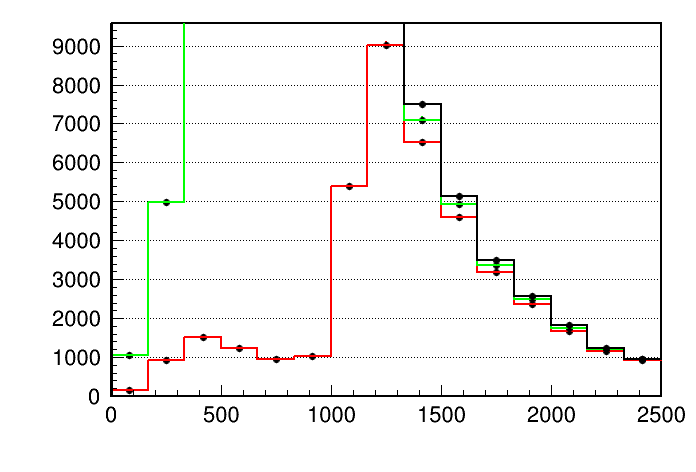

In [21]:
ctest = ROOT.TCanvas("test","test")
ctest.cd()

# hlt histo first to "zoom in"
h_num["24B"]["mjj"]['new'].SetLineColor(2)
h_num["24B"]["mjj"]['new'].Draw("hist e")

# then L1
h_num["24B"]["mjj"]['L1'].SetLineColor(3)
h_num["24B"]["mjj"]['L1'].Draw("hist e same")

# then denominator
h_den["24B"]["mjj"].Draw("hist e same")


#ctest.SetLogy()
ctest.SetGridy()
ctest.Draw()


In [22]:
#periods = ['23all','23mc','23C']
periods = ['24B','23all']
#periods = ['24B']
Eff = {}
for year in periods:
    print('Evaluating efficiencies for {}'.format(year))
    Eff[year] = {'mjj' : {}, 'pt1' : {}, 'pt2' : {},
                   'mjjraw' : {}, 'pt1raw' : {}, 'pt2raw' : {}}
    
    Eff[year]['mjj']['new']    = fill_eff(h_num, h_den, year, 'mjj', 'new')
    Eff[year]['mjj']['L1']     = fill_eff(h_num, h_den, year, 'mjj', 'L1' )
    
    #Eff[year]['pt1']['new']    = fill_eff(h_num, h_den, year, 'pt1', 'new')
    #Eff[year]['pt1']['L1']     = fill_eff(h_num, h_den, year, 'pt1', 'L1' )
    
    #Eff[year]['pt2']['new']    = fill_eff(h_num, h_den, year, 'pt2', 'new')
    #Eff[year]['pt2']['L1']     = fill_eff(h_num, h_den, year, 'pt2', 'L1' )
    
    #Eff[year]['mjjraw']['new']    = fill_eff(h_num, h_den, year, 'mjjraw', 'new')
    #Eff[year]['mjjraw']['L1']     = fill_eff(h_num, h_den, year, 'mjjraw', 'L1' )
    
    #Eff[year]['pt1raw']['new']    = fill_eff(h_num, h_den, year, 'pt1raw', 'new')
    #Eff[year]['pt1raw']['L1']     = fill_eff(h_num, h_den, year, 'pt1raw', 'L1' )
    
    #Eff[year]['pt2raw']['new']    = fill_eff(h_num, h_den, year, 'pt2raw', 'new')
    #Eff[year]['pt2raw']['L1']     = fill_eff(h_num, h_den, year, 'pt2raw', 'L1' )

Evaluating efficiencies for 24B
Evaluating efficiencies for 23all


In [23]:
# Definingvariables, categories & cuts

jet_vars = ['pt1','pt2','mjj','detajj','chf']

trigs = ['VBFincl','VBFjets','VBFmet' ,'VBFphot','VBFele' ,'VBFmu'  ,'VBFtau']


add_cut_label = {
    'mjj'    : ' ',
    'pt1' : 'm_{jj} > %.0f GeV' % (mjjcut),
    'pt2' : 'm_{jj} > %.0f GeV' % (mjjcut),
    'mjjraw'    : ' ',
    'pt1raw' : 'm_{jj} > %.0f GeV' % (mjjcut),
    'pt2raw' : 'm_{jj} > %.0f GeV' % (mjjcut),
}

# Plotting labels
VARLABELS = {
    'mjj'    : 'm_{jj} [GeV]',
    'pt1'    : 'Leading jet p_{T} [GeV]',
    'pt2'    : 'Subleading jet p_{T} [GeV]',    
    'mjjraw'    : 'm_{jj} [GeV]',
    'pt1raw'    : 'Leading jet p_{T} [GeV]',
    'pt2raw'    : 'Subleading jet p_{T} [GeV]',    
}

import CMS_lumi, tdrstyle
import array

tdrstyle.setTDRStyle()

#change the CMS_lumi variables (see CMS_lumi.py)
CMS_lumi.writeExtraText = True
CMS_lumi.extraText = "Preliminary"
#CMS_lumi.lumi_sqrtS = "22.1 fb^{-1}, 2023 (13.6 TeV)" # used with iPeriod = 0, e.g. for simulation-only plots (default is an empty string)
CMS_lumi.lumi_sqrtS = "2024B+C (13.6 TeV)" # used with iPeriod = 0, e.g. for simulation-only plots (default is an empty string)

iPeriod = 0
iPos = 0#11
H_ref = 600; 
W_ref = 600; 
W = W_ref
H = H_ref
# references for T, B, L, R
T = 0.08*H_ref
B = 0.14*H_ref 
L = 0.12*W_ref
R = 0.04*W_ref



Error in <TList::Clear>: A list is accessing an object (0x5574282660b0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x557428266550) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x557428266920) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x55742b6f6090) already deleted (list name = TList)


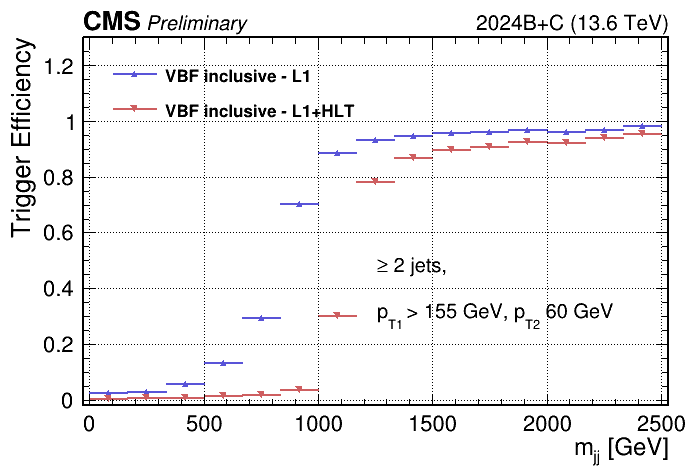

In [32]:
#######################################
### 2024 L1 vs L1+HLT
#######################################

theVar = 'mjj'

CMS_lumi.lumi_sqrtS = "2024B+C (13.6 TeV)" # used with iPeriod = 0, e.g. for simulation-only plots (default is an empty string)

path = {}
canvas = {}
hpx = {}
legend = {}
#for theVar in ['mjj','detajj','MET']:
text_coord = {
    'mjj' :    [1200,0.04,2400,0.57],
    'pt1' :    [100,0.1,240,0.7],
    'pt2' :    [100,0.1,240,0.7],
    'mjjraw' :    [1200,0.04,2400,0.57],
    'pt1raw' :    [100,0.1,240,0.7],
    'pt2raw' :    [100,0.1,240,0.7],
    'detajj' : [4.1,0.07,7.95,0.6],
    'MET' :    [170,0.04,390,0.64],
    'chf' :    [0.45,0.04,0.92,0.64]
    
}
#for theVar in ['mjj','detajj','chf']:
for theYear in ["24B"]:    
    Eff[theYear][theVar]['new'].SetLineColor(46)
    Eff[theYear][theVar]['new'].SetMarkerColor(46)
    Eff[theYear][theVar]['new'].SetLineWidth(2)
    Eff[theYear][theVar]['new'].SetMarkerStyle(23)   
    
    Eff[theYear][theVar]['L1'].SetLineColor(9)
    Eff[theYear][theVar]['L1'].SetMarkerColor(9)
    Eff[theYear][theVar]['L1'].SetLineWidth(2)
    Eff[theYear][theVar]['L1'].SetMarkerStyle(22)   
    
    path[theYear] = ROOT.TPaveText(text_coord[theVar][0],
                                  text_coord[theVar][1],
                                  text_coord[theVar][2],
                                  text_coord[theVar][3])
    
    path[theYear].SetTextAlign(12)
    path[theYear].SetFillStyle(0)
    path[theYear].SetBorderSize(0)

    #path[theYear].AddText('#geq 2 jets, #Delta#eta_{jj}>4.0')
    path[theYear].AddText('#geq 2 jets,')
    path[theYear].AddText('p_{T1} > %.0f GeV, p_{T2} %.0f GeV ' % (pt1cut,pt2cut)) 
    path[theYear].AddText(add_cut_label[theVar])
    
    canvas[theYear]=ROOT.TCanvas(theYear,"Trigger Efficicency")
    canvas[theYear].SetFillColor(0)
    canvas[theYear].SetBorderMode(0)
    canvas[theYear].SetFrameFillStyle(0)
    canvas[theYear].SetFrameBorderMode(0)
    canvas[theYear].SetLeftMargin( L/W )
    canvas[theYear].SetRightMargin( R/W )
    canvas[theYear].SetTopMargin( T/H )
    canvas[theYear].SetBottomMargin( B/H )
    canvas[theYear].SetTickx()
    canvas[theYear].SetTicky()
    canvas[theYear].SetGrid()
    canvas[theYear].cd()
  
    #dummy hist for consistent display
    xlow=Eff[theYear][theVar]['L1'].GetXaxis().GetBinLowEdge(0)
    xhigh=Eff[theYear][theVar]['L1'].GetXaxis().GetBinUpEdge(92)
    hpx[theYear] = ROOT.TH2F("hpx","",10,xlow,xhigh,10,-0.02,1.3)
    hpx[theYear].SetStats(False)
    hpx[theYear].SetTitle(theVar)
    hpx[theYear].GetXaxis().SetTitle(VARLABELS[theVar])
    hpx[theYear].GetYaxis().SetTitle("Trigger Efficiency")
    hpx[theYear].GetXaxis().SetTitleSize(0.055)
    hpx[theYear].GetXaxis().SetTitleOffset(1.1)
    hpx[theYear].GetYaxis().SetTitleSize(0.06)
    hpx[theYear].GetYaxis().SetTitleOffset(0.9)
    hpx[theYear].Draw()
    
    legend[theYear] = ROOT.TLegend(0.15,0.73,0.5,0.88) # top left
    legend[theYear].SetTextSize(0.04)
    legend[theYear].SetFillStyle(0)
    legend[theYear].SetBorderSize(0)
    legend[theYear].AddEntry(Eff[theYear][theVar]['L1'],   'VBF inclusive - L1',    'lp')
    legend[theYear].AddEntry(Eff[theYear][theVar]['new'],  'VBF inclusive - L1+HLT','lp')
    
    path[theYear].SetTextSize(0.045);
    
    Eff[theYear][theVar]['L1'].Draw("p same")
    Eff[theYear][theVar]['new'].Draw("p same")
    
    legend[theYear].Draw("same")
    path[theYear].Draw("same")
    canvas[theYear].Update()
    CMS_lumi.CMS_lumi(canvas[theYear], iPeriod, iPos)
    
    redrawBorder()
    
    #canvas[theVar].Draw()
    canvas[theYear].Draw()
    
    canvas[theYear].SaveAs(dir_in + "/plots/VBFincl_L1HLT_{}.20240509_STEAM.pdf".format(theVar))
    canvas[theYear].SaveAs(dir_in + "/plots/VBFincl_L1HLT_{}.20240509_STEAM.png".format(theVar))
    canvas[theYear].SaveAs(dir_in + "/plots/VBFincl_L1HLT_{}.20240509_STEAM.root".format(theVar))
    
    #canvas[theVar].SaveAs("./DPSplots/23C_vs_23D_VBFincl_{}.selCompCHFcut.data.pdf".format(theVar))
    #canvas[theVar].SaveAs("./DPSplots/23C_vs_23D_VBFincl_{}.selCompCHFcut.data.png".format(theVar))

Error in <TList::Clear>: A list is accessing an object (0x5574282660b0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x557428266550) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x557428266920) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x55742b6f6090) already deleted (list name = TList)


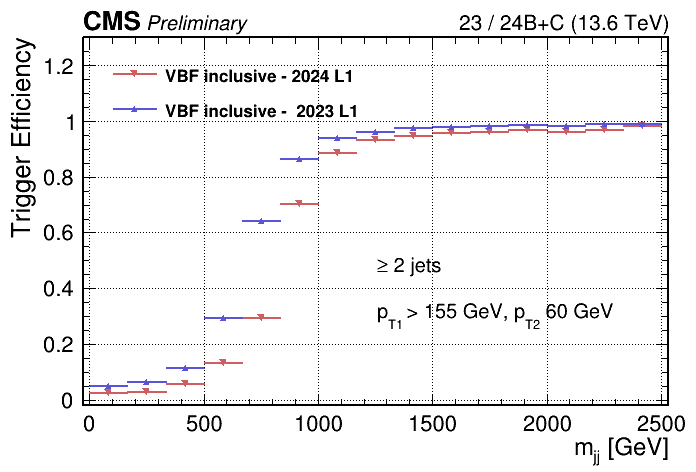

In [31]:
#######################################
### L1 2023 vs 2024
#######################################

CMS_lumi.lumi_sqrtS = "23 / 24B+C (13.6 TeV)" # used with iPeriod = 0, e.g. for simulation-only plots (default is an empty string)
theVar = 'mjj'

path = {}
canvas = {}
hpx = {}
legend = {}
#for theVar in ['mjj','detajj','MET']:
text_coord = {
    'mjj' :    [1200,0.04,2400,0.57],
    'pt1' :    [100,0.1,240,0.7],
    'pt2' :    [100,0.1,240,0.7],
    'mjjraw' :    [1200,0.04,2400,0.57],
    'pt1raw' :    [100,0.1,240,0.7],
    'pt2raw' :    [100,0.1,240,0.7],
    'detajj' : [4.1,0.07,7.95,0.6],
    'MET' :    [170,0.04,390,0.64],
    'chf' :    [0.45,0.04,0.92,0.64]
    
}


Eff['24B'][theVar]['L1'].SetLineColor(46)
Eff['24B'][theVar]['L1'].SetMarkerColor(46)
Eff['24B'][theVar]['L1'].SetLineWidth(2)
Eff['24B'][theVar]['L1'].SetMarkerStyle(23)   

Eff['23all'][theVar]['L1'].SetLineColor(9)
Eff['23all'][theVar]['L1'].SetMarkerColor(9)
Eff['23all'][theVar]['L1'].SetLineWidth(2)
Eff['23all'][theVar]['L1'].SetMarkerStyle(22)   

path['24B'] = ROOT.TPaveText(text_coord[theVar][0],
                              text_coord[theVar][1],
                              text_coord[theVar][2],
                              text_coord[theVar][3])

path['24B'].SetTextAlign(12)
path['24B'].SetFillStyle(0)
path['24B'].SetBorderSize(0)

#path['24B'].AddText('#geq 2 jets, #Delta#eta_{jj}>4.0')
path['24B'].AddText('#geq 2 jets')
path['24B'].AddText('p_{T1} > %.0f GeV, p_{T2} %.0f GeV ' % (pt1cut,pt2cut)) 
path['24B'].AddText(add_cut_label[theVar])

canvas['24B']=ROOT.TCanvas('24B',"Trigger Efficicency")
canvas['24B'].SetFillColor(0)
canvas['24B'].SetBorderMode(0)
canvas['24B'].SetFrameFillStyle(0)
canvas['24B'].SetFrameBorderMode(0)
canvas['24B'].SetLeftMargin( L/W )
canvas['24B'].SetRightMargin( R/W )
canvas['24B'].SetTopMargin( T/H )
canvas['24B'].SetBottomMargin( B/H )
canvas['24B'].SetTickx()
canvas['24B'].SetTicky()
canvas['24B'].SetGrid()
canvas['24B'].cd()

#dummy hist for consistent display
xlow=Eff['24B'][theVar]['L1'].GetXaxis().GetBinLowEdge(0)
xhigh=Eff['24B'][theVar]['L1'].GetXaxis().GetBinUpEdge(92)
hpx['24B'] = ROOT.TH2F("hpx","",10,xlow,xhigh,10,-0.02,1.3)
hpx['24B'].SetStats(False)
hpx['24B'].SetTitle(theVar)
hpx['24B'].GetXaxis().SetTitle(VARLABELS[theVar])
hpx['24B'].GetYaxis().SetTitle("Trigger Efficiency")
hpx['24B'].GetXaxis().SetTitleSize(0.055)
hpx['24B'].GetXaxis().SetTitleOffset(1.1)
hpx['24B'].GetYaxis().SetTitleSize(0.06)
hpx['24B'].GetYaxis().SetTitleOffset(0.9)
hpx['24B'].Draw()

legend['24B'] = ROOT.TLegend(0.15,0.73,0.5,0.88) # top left
legend['24B'].SetTextSize(0.04)
legend['24B'].SetFillStyle(0)
legend['24B'].SetBorderSize(0)
legend['24B'].AddEntry(Eff['24B'][theVar]['L1'],   'VBF inclusive - 2024 L1',    'lp')
legend['24B'].AddEntry(Eff['23all'][theVar]['L1'],  'VBF inclusive -  2023 L1','lp')

path['24B'].SetTextSize(0.045);

Eff['24B'][theVar]['L1'].Draw("p same")
Eff['23all'][theVar]['L1'].Draw("p same")

legend['24B'].Draw("same")
path['24B'].Draw("same")
canvas['24B'].Update()
CMS_lumi.CMS_lumi(canvas['24B'], iPeriod, iPos)

redrawBorder()

#canvas[theVar].Draw()
canvas['24B'].Draw()

canvas['24B'].SaveAs(dir_in + "/plots/VBFincl_L12324_{}.20240509_STEAM.pdf".format(theVar))
canvas['24B'].SaveAs(dir_in + "/plots/VBFincl_L12324_{}.20240509_STEAM.png".format(theVar))
canvas['24B'].SaveAs(dir_in + "/plots/VBFincl_L12324_{}.20240509_STEAM.root".format(theVar))
    
    #canvas[theVar].SaveAs("./DPSplots/23C_vs_23D_VBFincl_{}.selCompCHFcut.data.pdf".format(theVar))
    #canvas[theVar].SaveAs("./DPSplots/23C_vs_23D_VBFincl_{}.selCompCHFcut.data.png".format(theVar))

Error in <TList::Clear>: A list is accessing an object (0x5574282660b0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x557428266550) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x557428266920) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x55742b6f6090) already deleted (list name = TList)


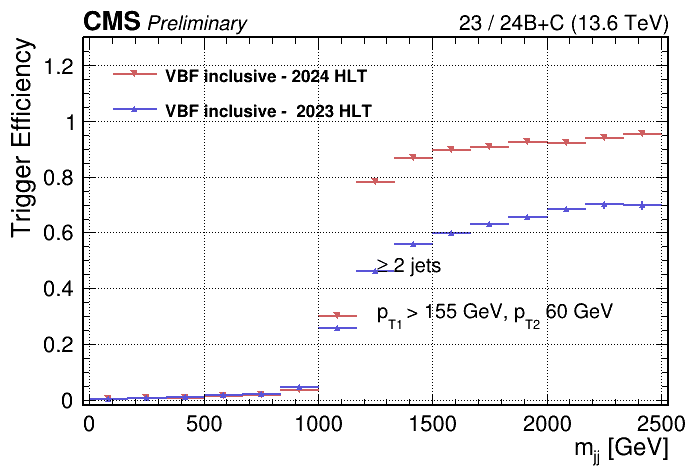

In [33]:
#######################################
### HLT 2023 vs 2024
#######################################

CMS_lumi.lumi_sqrtS = "23 / 24B+C (13.6 TeV)" # used with iPeriod = 0, e.g. for simulation-only plots (default is an empty string)
theVar = 'mjj'

path = {}
canvas = {}
hpx = {}
legend = {}
#for theVar in ['mjj','detajj','MET']:
text_coord = {
    'mjj' :    [1200,0.04,2400,0.57],
    'pt1' :    [100,0.1,240,0.7],
    'pt2' :    [100,0.1,240,0.7],
    'mjjraw' :    [1200,0.04,2400,0.57],
    'pt1raw' :    [100,0.1,240,0.7],
    'pt2raw' :    [100,0.1,240,0.7],
    'detajj' : [4.1,0.07,7.95,0.6],
    'MET' :    [170,0.04,390,0.64],
    'chf' :    [0.45,0.04,0.92,0.64]
    
}


Eff['24B'][theVar]['new'].SetLineColor(46)
Eff['24B'][theVar]['new'].SetMarkerColor(46)
Eff['24B'][theVar]['new'].SetLineWidth(2)
Eff['24B'][theVar]['new'].SetMarkerStyle(23)   

Eff['23all'][theVar]['new'].SetLineColor(9)
Eff['23all'][theVar]['new'].SetMarkerColor(9)
Eff['23all'][theVar]['new'].SetLineWidth(2)
Eff['23all'][theVar]['new'].SetMarkerStyle(22)   

path['24B'] = ROOT.TPaveText(text_coord[theVar][0],
                              text_coord[theVar][1],
                              text_coord[theVar][2],
                              text_coord[theVar][3])

path['24B'].SetTextAlign(12)
path['24B'].SetFillStyle(0)
path['24B'].SetBorderSize(0)

#path['24B'].AddText('#geq 2 jets, #Delta#eta_{jj}>4.0')
path['24B'].AddText('#geq 2 jets')
path['24B'].AddText('p_{T1} > %.0f GeV, p_{T2} %.0f GeV ' % (pt1cut,pt2cut)) 
path['24B'].AddText(add_cut_label[theVar])

canvas['24B']=ROOT.TCanvas('24B',"Trigger Efficicency")
canvas['24B'].SetFillColor(0)
canvas['24B'].SetBorderMode(0)
canvas['24B'].SetFrameFillStyle(0)
canvas['24B'].SetFrameBorderMode(0)
canvas['24B'].SetLeftMargin( L/W )
canvas['24B'].SetRightMargin( R/W )
canvas['24B'].SetTopMargin( T/H )
canvas['24B'].SetBottomMargin( B/H )
canvas['24B'].SetTickx()
canvas['24B'].SetTicky()
canvas['24B'].SetGrid()
canvas['24B'].cd()

#dummy hist for consistent display
xlow=Eff['24B'][theVar]['new'].GetXaxis().GetBinLowEdge(0)
xhigh=Eff['24B'][theVar]['new'].GetXaxis().GetBinUpEdge(92)
hpx['24B'] = ROOT.TH2F("hpx","",10,xlow,xhigh,10,-0.02,1.3)
hpx['24B'].SetStats(False)
hpx['24B'].SetTitle(theVar)
hpx['24B'].GetXaxis().SetTitle(VARLABELS[theVar])
hpx['24B'].GetYaxis().SetTitle("Trigger Efficiency")
hpx['24B'].GetXaxis().SetTitleSize(0.055)
hpx['24B'].GetXaxis().SetTitleOffset(1.1)
hpx['24B'].GetYaxis().SetTitleSize(0.06)
hpx['24B'].GetYaxis().SetTitleOffset(0.9)
hpx['24B'].Draw()

legend['24B'] = ROOT.TLegend(0.15,0.73,0.5,0.88) # top left
legend['24B'].SetTextSize(0.04)
legend['24B'].SetFillStyle(0)
legend['24B'].SetBorderSize(0)
legend['24B'].AddEntry(Eff['24B'][theVar]['new'],   'VBF inclusive - 2024 HLT',    'lp')
legend['24B'].AddEntry(Eff['23all'][theVar]['new'],  'VBF inclusive -  2023 HLT','lp')

path['24B'].SetTextSize(0.045);

Eff['24B'][theVar]['new'].Draw("p same")
Eff['23all'][theVar]['new'].Draw("p same")

legend['24B'].Draw("same")
path['24B'].Draw("same")
canvas['24B'].Update()
CMS_lumi.CMS_lumi(canvas['24B'], iPeriod, iPos)

redrawBorder()

#canvas[theVar].Draw()
canvas['24B'].Draw()

canvas['24B'].SaveAs(dir_in + "/plots/VBFincl_HLT2324_{}.20240509_STEAM.pdf".format(theVar))
canvas['24B'].SaveAs(dir_in + "/plots/VBFincl_HLT2324_{}.20240509_STEAM.png".format(theVar))
canvas['24B'].SaveAs(dir_in + "/plots/VBFincl_HLT2324_{}.20240509_STEAM.root".format(theVar))